# Modeling - Multiclass

In [13]:
import joblib
import splitfolders
import time
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers
from tensorflow.keras.utils import array_to_img, load_img, img_to_array, to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2
from keras.layers import Dropout
from keras.applications import imagenet_utils

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import datetime
original_start = datetime.datetime.now()
start = datetime.datetime.now()

import os, shutil

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

## Establish Image Directories

In [14]:
# location of all image datasets to be split 
input_folder = 'image_datasets/'

Split the images into train, test, and validation sets. 
- 60% Train
- 20% Validation
- 20% Test

In [15]:
# takes in all the image datasets to be split
# puts split images into datasets_split with 60% in train, 20% val, 20% test
splitfolders.ratio(input_folder, output = 'datasets_split',
                   seed = 42, ratio = (0.6, 0.2, 0.2))

Copying files: 6641 files [00:03, 2205.72 files/s]


Define location paths of each split image set. 

In [16]:
X_train = os.path.join('datasets_split/train/')
val_set = os.path.join('datasets_split/val/')
X_test = os.path.join('datasets_split/test/')

In [17]:
# check location
X_test

'datasets_split/test/'

## Preprocessing Images 

- Normalize
- Set up labels for each class


In [30]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                     X_train, 
                                                     target_size=(224, 224),
                                                     batch_size=3500) # total in train


val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                     val_set, 
                                                     target_size=(224, 224),
                                                     batch_size=1200) # total in val

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                     X_test, 
                                                     target_size=(224, 224),
                                                     batch_size=1200) # total in test

Found 3983 images belonging to 7 classes.
Found 1326 images belonging to 7 classes.
Found 1332 images belonging to 7 classes.


Create the labels:

In [31]:
# create the data sets and label the image classes
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

In [32]:
# check shape of images in train set
train_images.shape

(3500, 224, 224, 3)

In [33]:
# check labels for train
test_labels

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [34]:
# check what each image is classified as
class_labels = train_generator.class_indices
class_labels

{'baseball_bats': 0,
 'faces': 1,
 'guitar': 2,
 'gun': 3,
 'knives': 4,
 'people': 5,
 'phone': 6}

Label: [0. 0. 0. 0. 0. 1. 0.]


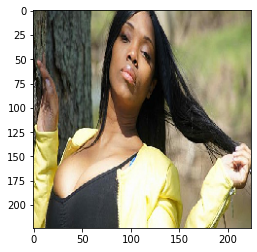

In [35]:
# check an example gun image
sample_train_image = train_images[5]
sample_train_label = train_labels[5]
display(plt.imshow(sample_train_image))
print('Label: {}'.format(sample_train_label))

Label: [0. 0. 0. 1. 0. 0. 0.]


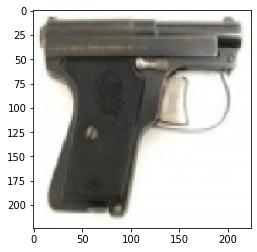

In [36]:
# check an example not gun image
sample_train_image = train_images[52]
sample_train_label = train_labels[52]
display(plt.imshow(sample_train_image))
print('Label: {}'.format(sample_train_label))

### Visualize the Image Dataset

In [37]:
# function that plots images and labels
def plots(ims, figsize = (20,4), rows = 1, interp = False, titles = None):
    """
    Takes in image set (recommend to slice for large sets); and image labels
    and plots a row of the images with associated labels.
    """
    if type(ims[0]) is np.ndarray:
        ims - np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims - ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 -- 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i +1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize = 16)
        plt.imshow(ims[i], interpolation = None if interp else 'none')

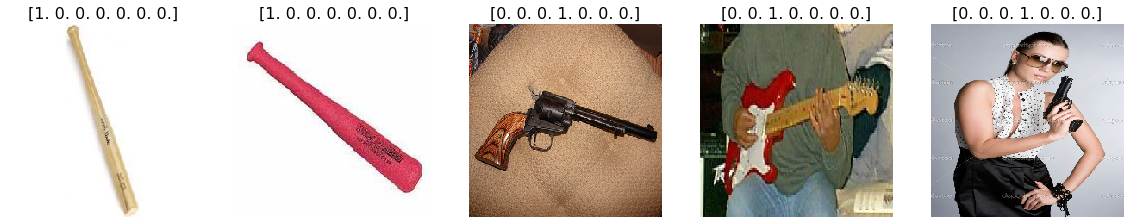

In [38]:
# peek at 5 images in the train set
plots(train_images[10:15], titles = train_labels[10:15])

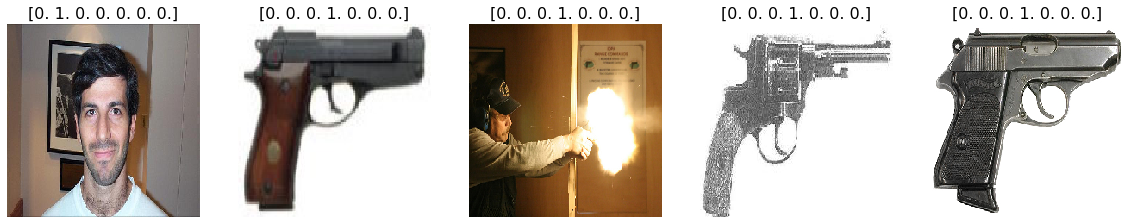

In [39]:
# peek at 5 images in the test set
plots(test_images[10:15], titles = test_labels[10:15])

In [40]:
# Explore dataset again
m_train = train_images.shape[0]  # number of images in train
num_px = train_images.shape[1]  # number of pixels
m_test = test_images.shape[0]  # number of images in test
m_val = val_images.shape[0]  # number of images in validation 

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print('-'*40)
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print('-'*40)
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print('-'*40)
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 3500
Number of testing samples: 1200
Number of validation samples: 1200
----------------------------------------
train_images shape: (3500, 224, 224, 3)
train_labels shape: (3500, 7)
----------------------------------------
test_images shape: (1200, 224, 224, 3)
test_labels shape: (1200, 7)
----------------------------------------
val_images shape: (1200, 224, 224, 3)
val_labels shape: (1200, 7)


### Reshaping the images in each set based on number of pixels

In [41]:
# reshapes the images to (num of images in set, num of pixels ie. 224 x 224 x 3 = 150528)
train_img = train_images.reshape(train_images.shape[0], -1) 
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(3500, 150528)
(1200, 150528)
(1200, 150528)


Refine the labels as the y train, validation, and test sets. 

In [42]:
train_labels

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [43]:
# # reshape the target 
# y_train = np.reshape(train_labels[:,0], (3983,1))
# y_val = np.reshape(val_labels[:,0], (1326,1))
# y_test = np.reshape(test_labels[:,0], (1332,1))

y_train = train_labels
y_val = val_labels
y_test = test_labels

In [46]:
# check test_y 
y_test[0:15]

array([[0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [47]:
y_test.shape

(1200, 7)

## Build Baseline Dense Network

In [48]:
# Build a baseline fully connected model
np.random.seed(42)

baseline_model = models.Sequential()

baseline_model.add(layers.Dense(128, activation='relu', input_shape=(150528,))) 

# 2 hidden layers
baseline_model.add(layers.Dense(64, activation='relu'))
baseline_model.add(layers.Dense(32, activation='relu'))
baseline_model.add(layers.Dense(7, activation='softmax')) # 7 different classes; ie. multiclass

Metal device set to: Apple M1


2022-08-03 23:34:00.270969: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-03 23:34:00.271449: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [49]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               19267712  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 7)                 231       
                                                                 
Total params: 19,278,279
Trainable params: 19,278,279
Non-trainable params: 0
_________________________________________________________________


In [50]:
# terminate training if doesnt improve on specified min_delta for 5 epochs
trainCallback = EarlyStopping(monitor='val_loss', min_delta = 1e-5, patience = 5)

**⏰ Below code runs for a few minutes**

In [71]:
train_img.shape

(3500, 150528)

In [51]:
baseline_model.compile(optimizer='Adam',
              loss='categorical_crossentropy', # for multiclass classification
              metrics=['accuracy'])

baseline_model = baseline_model.fit(train_img,
                                    y_train,
                                    epochs=30,
                                    batch_size=64,
                                    validation_data=(val_img, y_val),
                                    callbacks=[trainCallback])

2022-08-03 23:34:48.878649: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/30


2022-08-03 23:34:49.658502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - ETA: 0s - loss: 22.4937 - accuracy: 0.4349

2022-08-03 23:34:55.420853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 7s 122ms/step - loss: 22.4937 - accuracy: 0.4349 - val_loss: 9.0352 - val_accuracy: 0.3017
Epoch 2/30
55/55 [==============================] - 6s 103ms/step - loss: 5.6566 - accuracy: 0.5103 - val_loss: 17.4725 - val_accuracy: 0.6008
Epoch 3/30
55/55 [==============================] - 6s 102ms/step - loss: 6.3493 - accuracy: 0.5080 - val_loss: 1.4242 - val_accuracy: 0.5817
Epoch 4/30
55/55 [==============================] - 6s 104ms/step - loss: 1.4064 - accuracy: 0.6043 - val_loss: 1.2997 - val_accuracy: 0.6092
Epoch 5/30
55/55 [==============================] - 6s 103ms/step - loss: 1.4017 - accuracy: 0.5934 - val_loss: 1.7156 - val_accuracy: 0.4583
Epoch 6/30
55/55 [==============================] - 6s 103ms/step - loss: 1.6912 - accuracy: 0.5743 - val_loss: 1.6415 - val_accuracy: 0.5825
Epoch 7/30
55/55 [==============================] - 6s 102ms/step - loss: 1.2420 - accuracy: 0.6266 - val_loss: 1.7560 - val_accuracy: 0.5925
Epoch 8/30
55/5

### Save the model as a .pkl file 

In [53]:
# # use the built-in open() function to open a file
# output_file = open("baseline_model_multiclass.pkl", "wb") # "wb" means "write as bytes"

# # dump the variable's contents into the file
# joblib.dump(baseline_model, output_file)

# # close the file, ensuring nothing stays in the buffer
# output_file.close()

INFO:tensorflow:Assets written to: ram://48b4e156-e1ff-4c1c-94c6-b4897e6ff69d/assets


In [54]:
# use the built-in open() function again, this time to read
model_file = open("baseline_model_multiclass.pkl", "rb") # "rb" means "read as bytes"
# load the variable's contents from the file into a variable
loaded_baseline_model = joblib.load(model_file)
# close the file
model_file.close()

In [55]:
# create a helper function that returns loss and accuracy results from model
# also plots the loss and accuracy 

def model_results(mod, train_img, y_train, test_img, y_test):
    """ Takes in the model, image set, and array y of targets for training and test sets
        and returns the model's loss and accuracy scores.
        Also returns a plot of the training and validation scores. 
    """
    # returns loss and accuracy scores for training and test sets
    results_train = mod.model.evaluate(train_img, y_train)
    results_test = mod.model.evaluate(test_img, y_test)
    
    # get the accuracy and loss for training and validation
    acc = mod.history['accuracy']
    val_acc = mod.history['val_accuracy']
    loss = mod.history['loss']
    val_loss = mod.history['val_loss']
    epochs = range(len(acc))
    
    # return train and test loss and accuracy
    print("Train Results Loss:", round(results_train[0],5))
    print("Train Results Accuracy:", round(results_train[1], 5))
    print("-"* 50)
    print("Test Results Loss:", round(results_test[0],5))
    print("Test Results Accuracy:", round(results_test[1], 5))
    
    # plot the Traininng and Validation Accuracy and Loss
    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and Validation accuracy', fontweight = "bold")
    plt.ylabel('Accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and Validation loss', fontweight = "bold")
    plt.ylabel('Categorical Crossentropy Loss')
    plt.legend()
    plt.show()

### Baseline Model Results

2022-08-03 23:37:21.591833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 2s 50ms/step - loss: 1.2207 - accuracy: 0.6450
Train Results Loss: 0.82631
Train Results Accuracy: 0.73371
--------------------------------------------------
Test Results Loss: 1.22067
Test Results Accuracy: 0.645


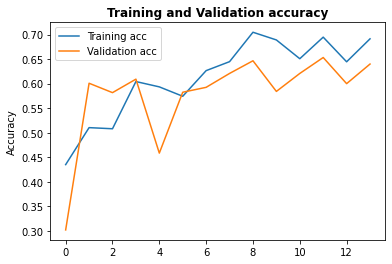

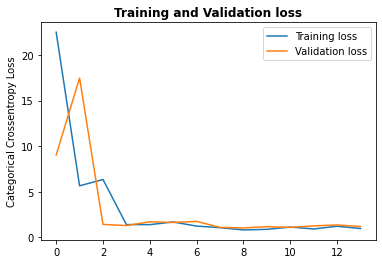

In [56]:
# get baseline model results
model_results(loaded_baseline_model, train_img, y_train, test_img, y_test)

In [57]:
# create helper function to plot test results as a confusion matrix
def get_test_results(mod, test_img, test_y):
    """
    Takes in the model, test image set, and test_y set
    and returns the model's accuracy and confusion matrix.
    """
    # return the loss and accuracy scores for the test set
    mod.model.evaluate(test_img, test_y)
    
    # get probabilites from the prediction on the test image set
    y_proba = mod.model.predict(test_img)
    
    # get assigned index values; ie. predicted labels
    predicted = np.argmax(y_proba, axis= -1)
    predicted
    
    # need to assign the class label to the actual y_test
    y_test_labeled = np.argmax(y_test, axis = -1)
    y_test_labeled

    # plot confusion matrix on test set
    cm = confusion_matrix(y_test_labeled, predicted)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm)

    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    
    # get class labels for reference
    print(class_labels)

 3/38 [=>............................] - ETA: 1s

2022-08-03 23:37:39.602741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 2s 53ms/step


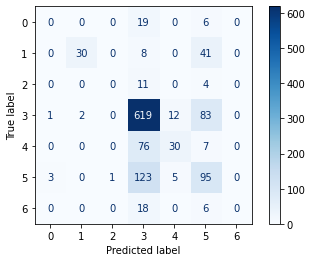

{'baseball_bats': 0, 'faces': 1, 'guitar': 2, 'gun': 3, 'knives': 4, 'people': 5, 'phone': 6}


In [58]:
# get confusion matrix and test results for test image set
get_test_results(loaded_baseline_model, test_img, y_test)

### Applying CNN with L1 (Lasso) Regularization
#### (aka. CNN Tuning V3 From Binary Classification Notebook)
Modifications performed:

- input shape must be in (224, 224, 3) form (ie. use `train_images` and NOT `train_img`
- changed to 7 outputs for last layer
- changed loss to categorical crossentropy

In [64]:
# establish the regularization strength of lambda
reg_l1 = l1(3e-3) # 1e-5 to .1

In [84]:
cnn_model_3 = models.Sequential()
cnn_model_3._name = "CNN3RegL1"

cnn_model_3.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3))) 

cnn_model_3.add(layers.MaxPooling2D((2, 2)))

cnn_model_3.add(layers.Conv2D(32, (4, 4), activation='relu')) 
cnn_model_3.add(layers.MaxPooling2D((2, 2)))

cnn_model_3.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model_3.add(layers.MaxPooling2D((2, 2)))

cnn_model_3.add(layers.Flatten())
cnn_model_3.add(layers.Dense(64, 
                             activation='relu',
                             kernel_regularizer = reg_l1)) # added l1 regularization
cnn_model_3.add(layers.Dense(7, activation='softmax'))  

cnn_model_3.compile(loss='categorical_crossentropy', # for multiclass classification
              optimizer="adam",  
              metrics=['accuracy'])

**⏰ Below code runs for about 7 minutes**

In [85]:
# create a CNN model for multiclass
cnn_model_multiclass = cnn_model_3.fit(train_images,
                                        y_train,
                                        epochs=30,
                                        batch_size=64,
                                        validation_data=(val_images, y_val),
                                        callbacks=[trainCallback])

Epoch 1/30


2022-08-03 23:49:30.542992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - ETA: 0s - loss: 9.4841 - accuracy: 0.5834

2022-08-03 23:49:50.621448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 23s 407ms/step - loss: 9.4841 - accuracy: 0.5834 - val_loss: 2.8252 - val_accuracy: 0.5883
Epoch 2/30
55/55 [==============================] - 21s 375ms/step - loss: 2.6243 - accuracy: 0.5951 - val_loss: 2.5663 - val_accuracy: 0.5400
Epoch 3/30
55/55 [==============================] - 21s 376ms/step - loss: 2.3869 - accuracy: 0.6094 - val_loss: 2.5886 - val_accuracy: 0.4683
Epoch 4/30
55/55 [==============================] - 20s 372ms/step - loss: 2.3187 - accuracy: 0.6174 - val_loss: 2.2614 - val_accuracy: 0.6283
Epoch 5/30
55/55 [==============================] - 21s 374ms/step - loss: 2.2406 - accuracy: 0.6329 - val_loss: 2.2551 - val_accuracy: 0.6358
Epoch 6/30
55/55 [==============================] - 21s 381ms/step - loss: 2.2903 - accuracy: 0.6346 - val_loss: 2.2315 - val_accuracy: 0.6517
Epoch 7/30
55/55 [==============================] - 21s 382ms/step - loss: 2.1899 - accuracy: 0.6731 - val_loss: 2.2464 - val_accuracy: 0.6392
Epoch 8/30

**.pkl the file**

In [87]:
# # use the built-in open() function to open a file
# output_file = open("cnn_model_multiclass.pkl", "wb") # "wb" means "write as bytes"

# # dump the variable's contents into the file
# joblib.dump(cnn_model_multiclass, output_file)

# # close the file, ensuring nothing stays in the buffer
# output_file.close()

In [88]:
# use the built-in open() function again, this time to read
cnn_model_multiclass_file = open("cnn_model_multiclass.pkl", "rb") # "rb" means "read as bytes"
# load the variable's contents from the file into a variable
loaded_cnn_model_multiclass = joblib.load(cnn_model_multiclass_file)
# close the file
cnn_model_multiclass_file.close()

### CNN Tuning V3 with L1 (Lasso) Regularization Results

2022-08-03 23:58:25.914326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 3s 72ms/step - loss: 2.0575 - accuracy: 0.7225
Train Results Loss: 1.85552
Train Results Accuracy: 0.78714
--------------------------------------------------
Test Results Loss: 2.05753
Test Results Accuracy: 0.7225


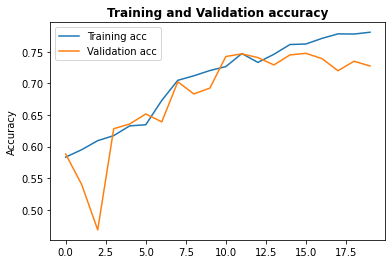

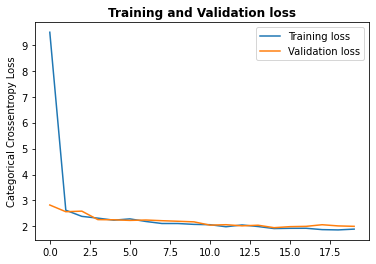

In [90]:
# get model results
model_results(loaded_cnn_model_multiclass, train_images, y_train, test_images, y_test)

 1/38 [..............................] - ETA: 4s

2022-08-03 23:58:50.874676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 3s 76ms/step


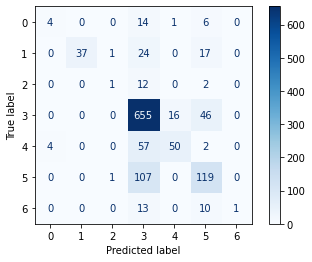

{'baseball_bats': 0, 'faces': 1, 'guitar': 2, 'gun': 3, 'knives': 4, 'people': 5, 'phone': 6}


In [92]:
# get confusion matrix and test results for test image set
get_test_results(loaded_cnn_model_multiclass, test_images, y_test)